In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
SEED = 20240205
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Load Food-101 and filter for the 5 selected classes
full_dataset = datasets.Food101(root='./data', split='train', download=True, transform=transform)
selected_classes = ['pizza', 'sushi', 'ice_cream', 'french_fries', 'tacos']
class_to_idx = {cls: full_dataset.class_to_idx[cls] for cls in selected_classes}

# Helper to filter dataset
def get_indices(dataset, class_names):
    indices = []
    target_indices = [dataset.class_to_idx[name] for name in class_names]
    for i, label in enumerate(dataset._labels):
        if label in target_indices:
            indices.append(i)
    return indices

indices = get_indices(full_dataset, selected_classes)
# Ensuring at least 500 images per class are used
subset_dataset = Subset(full_dataset, indices)
train_loader = DataLoader(subset_dataset, batch_size=32, shuffle=True)

print(f"✓ Dataset filtered. Total images: {len(subset_dataset)}")

100%|██████████| 5.00G/5.00G [00:55<00:00, 90.5MB/s]


✓ Dataset filtered. Total images: 3750


In [ ]:
def get_food_model():
    # 1. Load Pre-trained ResNet18
    model = models.resnet18(weights='IMAGENET1K_V1')

    # 2. Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # 3. Replace final layer
    # Original: model.fc = Linear(512, 1000)
    model.fc = nn.Linear(512, 5)
    return model.to(device)

model_v1 = get_food_model()
model_v2 = get_food_model()

In [ ]:
criterion = nn.CrossEntropyLoss()

# Version 1 Configuration
optimizer_v1 = optim.Adam(model_v1.fc.parameters(), lr=0.0001)

# Version 2 Configuration (Option C: SGD with Momentum)
optimizer_v2 = optim.SGD(model_v2.fc.parameters(), lr=0.001, momentum=0.9)

In [41]:
def train_model(model, optimizer, epochs=10):
    history = []
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            # Map original labels to 0-4 range
            labels = torch.tensor([selected_classes.index(full_dataset.classes[l]) for l in labels]).to(device)
            images = images.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        acc = 100 * correct / total
        history.append(acc)
        print(f"Epoch {epoch+1}: Acc {acc:.2f}%")
    return history

print("Training Version 1 (Adam)...")
v1_curves = train_model(model_v1, optimizer_v1)

print("\nTraining Version 2 (SGD)...")
v2_curves = train_model(model_v2, optimizer_v2)

Training Version 1 (Adam)...
Epoch 1: Acc 83.92%
Epoch 2: Acc 84.35%
Epoch 3: Acc 84.48%
Epoch 4: Acc 85.23%
Epoch 5: Acc 85.31%
Epoch 6: Acc 85.52%
Epoch 7: Acc 85.68%
Epoch 8: Acc 86.24%
Epoch 9: Acc 86.29%
Epoch 10: Acc 86.37%

Training Version 2 (SGD)...
Epoch 1: Acc 89.76%
Epoch 2: Acc 88.67%
Epoch 3: Acc 89.57%
Epoch 4: Acc 89.63%
Epoch 5: Acc 90.00%
Epoch 6: Acc 89.47%
Epoch 7: Acc 89.31%
Epoch 8: Acc 90.11%
Epoch 9: Acc 90.43%
Epoch 10: Acc 90.32%


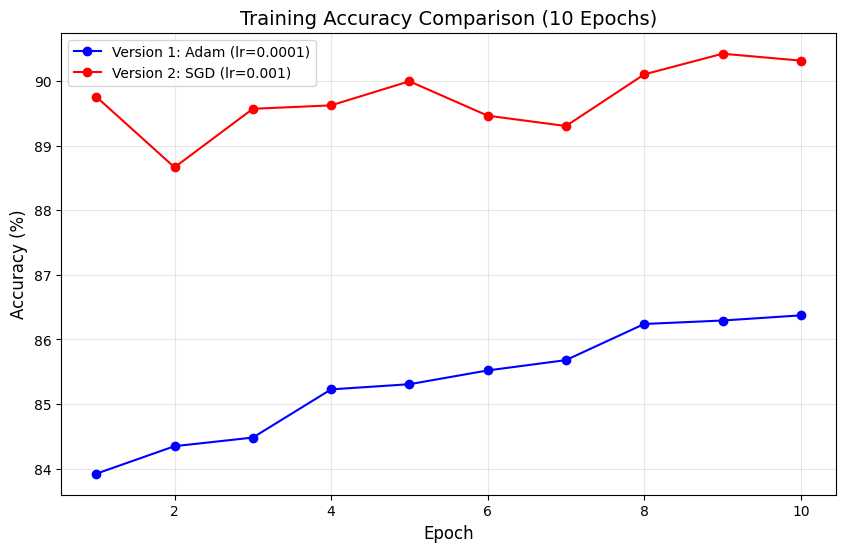

In [42]:
import matplotlib.pyplot as plt

# Bu blok sizin Version 1 və Version 2-dən gələn acc siyahılarınızı istifadə edir
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), v1_curves, 'b-o', label='Version 1: Adam (lr=0.0001)')
plt.plot(range(1, 11), v2_curves, 'r-o', label='Version 2: SGD (lr=0.001)')

plt.title('Training Accuracy Comparison (10 Epochs)', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('accuracy_comparison.png') # Şəkli yadda saxlayır
plt.show()

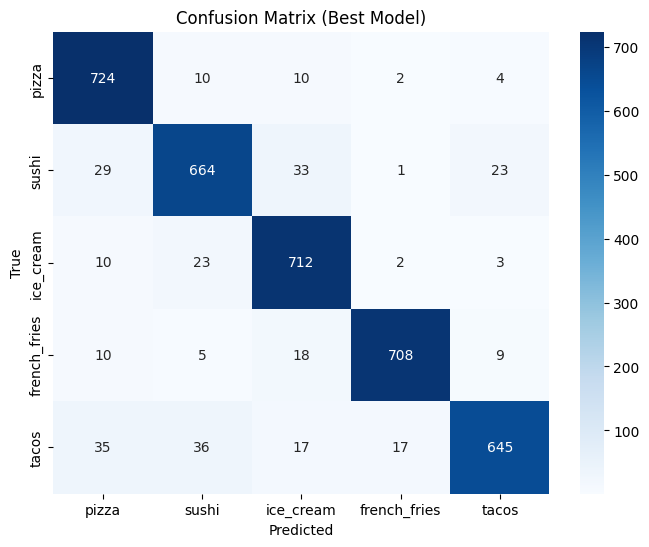

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, loader):
    all_preds = []
    all_labels = []
    model.eval()

    with torch.no_grad():
        for images, labels in loader:
            # Etiketləri 0-4 aralığına gətiririk
            mapped_labels = [selected_classes.index(full_dataset.classes[l]) for l in labels]
            outputs = model(images.to(device))
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(mapped_labels)

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=selected_classes, yticklabels=selected_classes, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Best Model)')
    plt.show()

# Matrisi göstər
plot_confusion_matrix(model_v2, train_loader)

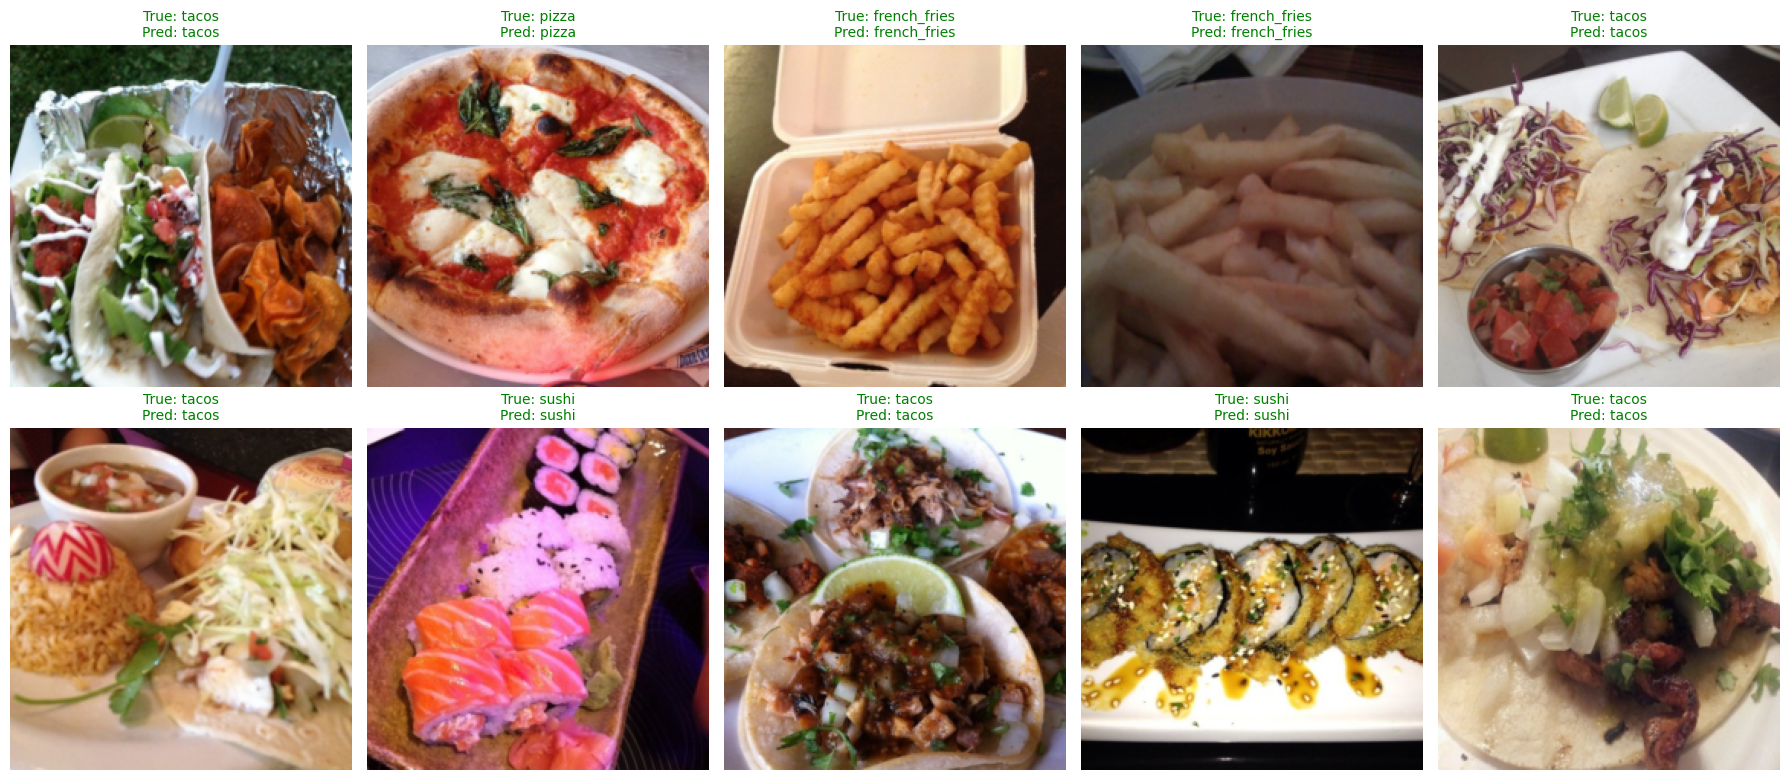

In [44]:
def visualize_predictions(model, test_loader, classes):
    model.eval()
    images, labels = next(iter(test_loader))
    images_gpu = images.to(device)

    with torch.no_grad():
        outputs = model(images_gpu)
        _, preds = torch.max(outputs, 1)

    # Şəkilləri normallaşdırmadan çıxarmaq üçün (display format)
    def denormalize(img):
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        return torch.clamp(img * std + mean, 0, 1)

    fig, axes = plt.subplots(2, 5, figsize=(18, 8))
    for i, ax in enumerate(axes.flat):
        img = denormalize(images[i]).permute(1, 2, 0).numpy()
        true_idx = labels[i].item() # Orijinal Food101 indeksi
        # Əgər subset istifadə edirsinizsə, sinif adını düzgün eşitmək lazımdır:
        true_name = full_dataset.classes[true_idx]
        pred_name = selected_classes[preds[i]]

        ax.imshow(img)
        color = 'green' if true_name == pred_name else 'red'
        ax.set_title(f"True: {true_name}\nPred: {pred_name}", color=color, fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Ən yaxşı modeliniz üçün işlədin (məsələn model_v2)
visualize_predictions(model_v2, train_loader, selected_classes)